# Starting Off
Slack me the answer to the following questions:

What is the difference between a bagging and boosting algorithm?

What is a reason you might choose one algorithm over the other?

# Classification Practicum with Class Imbalance

Agenda:
- Review class imbalance
- Review code for different ways to handle class imbalance
- Review code for Random Forest with gridsearch


In [1]:
import pandas as pd
import numpy as np
from sklearn import metrics

In [2]:
# Read in data and split data to be used in the models
titanic = pd.read_csv('https://raw.githubusercontent.com/learn-co-students/nyc-mhtn-ds-042219-lectures/master/Module_4/cleaned_titanic.csv', index_col='PassengerId')



In [3]:
# Create matrix of features
X = titanic.drop('Survived', axis = 1) # grabs everything else but 'Survived'

# Create target variable
y = titanic['Survived'] # y is the column we're trying to predict

# Create a list of the features being used in the 
feature_cols = X.columns

# Handling Class Imbalance

## Visualizing Class Imbalance

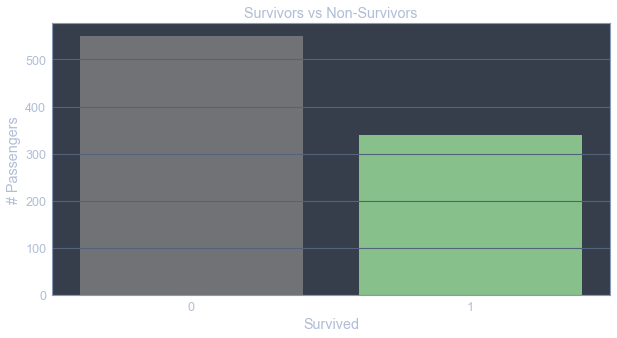

In [4]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline  

# sns.set_style('darkgrid')
plt.figure(figsize = (10,5))
sns.countplot(y, alpha =.80, palette= ['grey','lightgreen'])
plt.title('Survivors vs Non-Survivors')
plt.ylabel('# Passengers')
plt.show()

## Run a Dummy Classifier for Baseline Assessment

In [5]:
1-y.mean()

0.6175478065241844

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, f1_score

# setting up testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=23)

# DummyClassifier to predict only target 0
dummy = DummyClassifier(strategy='most_frequent').fit(X_train, y_train)
dummy_pred = dummy.predict(X_test)




**Questions:**

- What do you think the accuracy score will be for this model?
- What do you think the F-1 Score will be for this model?

In [7]:

# checking accuracy
print('Test Accuracy score: ', accuracy_score(y_test, dummy_pred))


# checking accuracy
print('Test F1 score: ', f1_score(y_test, dummy_pred))

Test Accuracy score:  0.6547085201793722
Test F1 score:  0.0


# Handling Class Imbalance

In this guide, we will cover 5 tactics for handling imbalanced classes in machine learning:

1. Up-sample the minority class
2. Down-sample the majority class
3. Change your performance metric
4. Penalize algorithms (cost-sensitive training)
5. Use tree-based algorithms

## Run a classification Model with class imbalance

Before we start to implement different ways to handle class imbalance, let's fit a basic model to have a better point of comparison.  

In [8]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(solver='liblinear')

lr_clf.fit(X_train, y_train)

y_pred_test = lr_clf.predict(X_test)


# checking accuracy
print('Test Accuracy score: ', accuracy_score(y_test, y_pred_test))


# checking accuracy
print('Test F1 score: ', f1_score(y_test, y_pred_test))

Test Accuracy score:  0.7847533632286996
Test F1 score:  0.6619718309859155


In [9]:
results = {}

results['imbalanced'] = (accuracy_score(y_test, y_pred_test), f1_score(y_test, y_pred_test))

In [14]:
results

{'imbalanced': (0.7847533632286996, 0.6619718309859155)}

## Prepping data for handling class imbalances

We are goign to change the training dataset to which we fit our model, so we want to bring our training data back together before we make those changes. 

In [15]:
# concatenate our training data back together
training  = pd.concat([X_train, y_train], axis=1)

In [16]:
# separate minority and majority classes
deceased = training[training.Survived==0]
survived = training[training.Survived==1]

In [17]:
# Get a class count to understand the class imbalance.
print('deceased count: '+ str(len(deceased)))
print('survived count: '+ str(len(survived)))

deceased count: 403
survived count: 263


## Resampling 
You can change the dataset that you use to build your predictive model to have more balanced data.

This change is called sampling your dataset and there are two main methods that you can use to even-up the classes:

You can add copies of instances from the under-represented class called over-sampling (or more formally sampling with replacement), or
You can delete instances from the over-represented class, called under-sampling.
These approaches are often very easy to implement and fast to run. They are an excellent starting point.


**Some Rules of Thumb:**
- Consider testing under-sampling when you have an a lot data (tens- or hundreds of thousands of instances or more)
- Consider testing over-sampling when you don’t have a lot of data (tens of thousands of records or less)
- Consider testing random and non-random (e.g. stratified) sampling schemes.
- Consider testing different resampled ratios (e.g. you don’t have to target a 1:1 ratio in a binary classification problem, try other ratios)

![alt text](images/resampling.png)

In [18]:
from sklearn.utils import resample


### Upsampling



In [19]:
# upsample minority
survived_upsampled = resample(survived,
                          replace=True, # sample with replacement
                          n_samples=len(deceased), # match number in majority class
                          random_state=23) # reproducible results

In [20]:
survived_upsampled.shape

(403, 10)

In [22]:
# combine majority and upsampled minority
upsampled = pd.concat([deceased, survived_upsampled])

# check new class counts
upsampled.Survived.value_counts()

1    403
0    403
Name: Survived, dtype: int64

In [24]:
len(upsampled)

806

Now that we have balanced classes, lets see how this can affect the performance of the model.  

In [25]:
# trying logistic regression again with the balanced dataset
y_train = upsampled.Survived
X_train = upsampled.drop('Survived', axis=1)


# upsampled_dt = DecisionTreeClassifier(max_depth=5)
upsampled_lr = LogisticRegression(solver='liblinear')


# upsampled_dt.fit(X_train, y_train)
upsampled_lr.fit(X_train, y_train)


# upsampled_pred = upsampled_dt.predict(X_test)
upsampled_pred = upsampled_lr.predict(X_test)



# checking accuracy
print('Test Accuracy score: ', accuracy_score(y_test, upsampled_pred))


# checking accuracy
print('Test F1 score: ', f1_score(y_test, upsampled_pred))



Test Accuracy score:  0.7713004484304933
Test F1 score:  0.6577181208053691


In [26]:
results['upsampled'] = (accuracy_score(y_test, upsampled_pred), f1_score(y_test, upsampled_pred))

In [27]:
results

{'imbalanced': (0.7847533632286996, 0.6619718309859155),
 'upsampled': (0.7713004484304933, 0.6577181208053691)}

## Downsampling

In [28]:
# downsample majority
survived_downsampled = resample(deceased,
                                replace = False, # sample without replacement
                                n_samples = len(survived), # match minority n
                                random_state = 23) # reproducible results

In [29]:
# combine minority and downsampled majority
downsampled = pd.concat([survived_downsampled, survived])

# checking counts
downsampled.Survived.value_counts()

1    263
0    263
Name: Survived, dtype: int64

In [30]:
# trying logistic regression again with the balanced dataset
y_train = downsampled.Survived
X_train = downsampled.drop('Survived', axis=1)


# downsampled_dt = DecisionTreeClassifier(max_depth=5)
downsampled_lr = LogisticRegression(solver='liblinear')


# downsampled_dt.fit(X_train, y_train)
downsampled_lr.fit(X_train, y_train)

# downsampled_pred = upsampled_dt.predict(X_test)
downsampled_pred = downsampled_lr.predict(X_test)

# checking accuracy
print('Test Accuracy score: ', accuracy_score(y_test, downsampled_pred))

# checking accuracy
print('Test F1 score: ', f1_score(y_test, downsampled_pred))

Test Accuracy score:  0.7802690582959642
Test F1 score:  0.6711409395973155


In [31]:
results['downsampled'] = (accuracy_score(y_test, downsampled_pred), f1_score(y_test, downsampled_pred))

In [32]:
results

{'imbalanced': (0.7847533632286996, 0.6619718309859155),
 'upsampled': (0.7713004484304933, 0.6577181208053691),
 'downsampled': (0.7802690582959642, 0.6711409395973155)}

## Over-sampling: SMOTE

SMOTE (Synthetic Minority Oversampling Technique) consists of synthesizing elements for the minority class, based on those that already exist. It works randomly picking a point from the minority class and computing the k-nearest neighbors for this point. The synthetic points are added between the chosen point and its neighbors.

![alt text](images/smote.png)

In [33]:
from imblearn.over_sampling import SMOTE

Using TensorFlow backend.
/Users/eric/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/eric/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/eric/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/eric/opt/anaconda3/lib/python3.7/site-pa

In [35]:
sm = SMOTE(sampling_strategy=1.0, random_state=23)
X_train, y_train = sm.fit_sample(X_train, y_train)

ValueError: The specified ratio required to remove samples from the minority class while trying to generate new samples. Please increase the ratio.

In [36]:
def fit_predict(model, x_train, y_train, test):
    model.fit(x_train, y_train)
    predictions = model.predict(test)
    # checking accuracy
    print('Test Accuracy score: ', accuracy_score(test, prediction))

    # checking accuracy
    print('Test F1 score: ', f1_score(test, predictions))


In [37]:
lr = LogisticRegression(solver='liblinear')

In [38]:
# smote_dt = DecisionTreeClassifier(max_depth=5)
smote_lr = LogisticRegression(solver='liblinear')

# smote_dt.fit(X_train, y_train)
smote_lr.fit(X_train, y_train)

# smote_pred = smote_dt.predict(X_test)
smote_pred = smote_lr.predict(X_test)

# checking accuracy
print('Test Accuracy score: ', accuracy_score(y_test, smote_pred))

# checking accuracy
print('Test F1 score: ', f1_score(y_test, smote_pred))

Test Accuracy score:  0.7802690582959642
Test F1 score:  0.6711409395973155


In [39]:
fit_predict()

TypeError: fit_predict() missing 4 required positional arguments: 'model', 'x_train', 'y_train', and 'test'

In [40]:
results['smote'] = (accuracy_score(y_test, smote_pred), f1_score(y_test, smote_pred))

## Under-sampling: Tomek links

Tomek links are pairs of very close instances, but of opposite classes. Removing the instances of the majority class of each pair increases the space between the two classes, facilitating the classification process.

![alt text](images/tomek.png)

In [41]:
from collections import Counter
from imblearn.under_sampling import TomekLinks # doctest: +NORMALIZE_WHITESPACE



In [42]:
tl = TomekLinks()
X_res, y_res = tl.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_res))


Resampled dataset shape Counter({0: 263, 1: 222})


In [43]:
feature_cols

Index(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'youngin', 'male', 'Q', 'S'], dtype='object')

In [44]:
tl.sample_indices_

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [45]:
# remove Tomek links
tl = TomekLinks()
X_resampled, y_resampled = tl.fit_sample(X_train, y_train)



TypeError: '(0       True
1       True
2       True
3       True
4       True
       ...  
480    False
481    False
482    False
483    False
484    False
Name: Survived, Length: 485, dtype: bool, 1)' is an invalid key

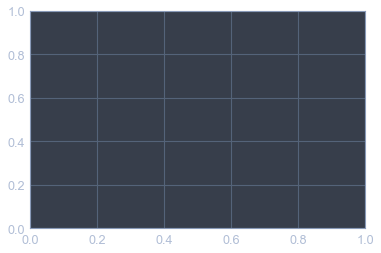

In [46]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

idx_samples_removed = np.setdiff1d(np.arange(X_train.shape[0]),
                                   tl.sample_indices_)
idx_class_0 = y_resampled == 0
plt.scatter(X_resampled[idx_class_0, 1], X_resampled[idx_class_0, 4],
            alpha=.8, label='Class #0')
plt.scatter(X_resampled[~idx_class_0, 1], X_resampled[~idx_class_0, 4],
            alpha=.8, label='Class #1')
plt.scatter(X_train[idx_samples_removed, 1], X_train[idx_samples_removed, 4],
             alpha=.8, label='Removed samples')

In [47]:
len(idx_samples_removed)

41

In [48]:
len(X_train)

526

In [49]:
len(X_resampled)

485

In [50]:
tomek_lr = LogisticRegression(solver='liblinear')

tomek_lr.fit(X_resampled, y_resampled)

tomek_pred = tomek_lr.predict(X_test)

# checking accuracy
print('Test Accuracy score: ', accuracy_score(y_test, tomek_pred))


# checking accuracy
print('Test F1 score: ', f1_score(y_test, tomek_pred))

Test Accuracy score:  0.7757847533632287
Test F1 score:  0.6621621621621622


In [51]:
results['tomek'] = (accuracy_score(y_test, tomek_pred), f1_score(y_test, tomek_pred))

In [52]:
results

{'imbalanced': (0.7847533632286996, 0.6619718309859155),
 'upsampled': (0.7713004484304933, 0.6577181208053691),
 'downsampled': (0.7802690582959642, 0.6711409395973155),
 'smote': (0.7802690582959642, 0.6711409395973155),
 'tomek': (0.7757847533632287, 0.6621621621621622)}

### Penalize Algorithms (Cost-Sensitive Training)
The next tactic is to use penalized learning algorithms that increase the cost of classification mistakes on the minority class.

During training, we can use the argument `class_weight='balanced'`  to penalize mistakes on the minority class by an amount proportional to how under-represented it is.

In [53]:
lr_clf_weighted = LogisticRegression(solver='liblinear', class_weight='balanced')

lr_clf_weighted.fit(X_train, y_train)

y_weighted_test = lr_clf_weighted.predict(X_test)


# checking accuracy
print('Test Accuracy score: ', accuracy_score(y_test, y_weighted_test))


# checking accuracy
print('Test F1 score: ', f1_score(y_test, y_weighted_test))

Test Accuracy score:  0.7802690582959642
Test F1 score:  0.6711409395973155


In [54]:
results['weighted'] = (accuracy_score(y_test, y_weighted_test), f1_score(y_test, y_weighted_test))

In [55]:
results

{'imbalanced': (0.7847533632286996, 0.6619718309859155),
 'upsampled': (0.7713004484304933, 0.6577181208053691),
 'downsampled': (0.7802690582959642, 0.6711409395973155),
 'smote': (0.7802690582959642, 0.6711409395973155),
 'tomek': (0.7757847533632287, 0.6621621621621622),
 'weighted': (0.7802690582959642, 0.6711409395973155)}

## Tree-Based Algorithms

Decision trees often perform well on imbalanced datasets because their hierarchical structure allows them to learn signals from both classes.

In [56]:
# Instantiate the classifier using 200 trees
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(random_state = 23, n_estimators=200)

In [57]:
#fit the model to the training data
rfc.fit(X_train, y_train)

#use the fitted model to predict on the test data
rfc_pred = rfc.predict(X_test)


# checking accuracy on the test data
print('Test Accuracy score: ', accuracy_score(y_test, rfc_pred))


# checking accuracy on the test data
print('Test F1 score: ', f1_score(y_test, rfc_pred))

Test Accuracy score:  0.7623318385650224
Test F1 score:  0.6666666666666666


In [58]:
results['rfc'] = (accuracy_score(y_test, rfc_pred), f1_score(y_test, rfc_pred))

In [59]:
results

{'imbalanced': (0.7847533632286996, 0.6619718309859155),
 'upsampled': (0.7713004484304933, 0.6577181208053691),
 'downsampled': (0.7802690582959642, 0.6711409395973155),
 'smote': (0.7802690582959642, 0.6711409395973155),
 'tomek': (0.7757847533632287, 0.6621621621621622),
 'weighted': (0.7802690582959642, 0.6711409395973155),
 'rfc': (0.7623318385650224, 0.6666666666666666)}

## Change Your Performance Metric

Accuracy is not the metric to use when working with an imbalanced dataset. We have seen that it is misleading.

There are metrics that have been designed to tell you a more truthful story when working with imbalanced classes.

- Precision: A measure of a classifiers exactness.
- Recall: A measure of a classifiers completeness
- F1 Score (or F-score): A weighted average of precision and recall.

- Kappa (or Cohen’s kappa): Classification accuracy normalized by the imbalance of the classes in the data.
- ROC Curves: Like precision and recall, accuracy is divided into sensitivity and specificity and models can be chosen based on the balance thresholds of these values.

When using a cross-validation method, you can utilize one of these as the scoring metric when comparing across multiple methods.  

This will not change the way a model is fitted, it will just choose a different model as the **best_estimator** based on the scoring metric. 

In [60]:
from sklearn.model_selection import GridSearchCV

In [61]:
#create a dictionary of all the parameters you want to tune
param_grid = { 
    'n_estimators': [100,200,300,400],
    param2: list_of_options,
    param3: list_of_options,
    param4: list_of_options,
}

NameError: name 'param2' is not defined

In [ ]:
#create a grid search object and fit it to the data

CV_rfc = GridSearchCV(_______, ________, cv=____,n_jobs=____, scoring= ____)
CV_rfc.fit(_____, _____)

In [ ]:
### Identify the best params 
print(CV_rfc.____)


#Identify the best score during fitting with cross-validation
print(CV_rfc.best_score_)


In [ ]:
#predict on the test set

rfc_pred = ____.best_estimator_.____(_____)

# checking accuracy
print('Test Accuracy score: ', accuracy_score(_____, _____))


# checking accuracy
print('Test F1 score: ', f1_score(_____, _____))

In [ ]:
# add to results dictionary

results[____] = (accuracy_score(y_test, _____), f1_score(y_test, _____))

## Reframe as Anomaly Detection

If your class imbalance is very extreme (less than 0.1%), it might be better to treat this as an anomay detection problem than a classification problem.  
**Anomaly detection**, a.k.a. outlier detection, is for detecting outliers and rare events. Instead of building a classification model, you'd have a "profile" of a normal observation. If a new observation strays too far from that "normal profile," it would be flagged as an anomaly.

https://towardsdatascience.com/anomaly-detection-for-dummies-15f148e559c1

In [ ]:
results